#Dataset Condensation

This notebook is my implementaion of <a href = "https://arxiv.org/abs/2006.05929">Dataset Condensation with Gradient Matching</a> 

The number of data to train deep learning model is getting bigger and bigger, for example the data used for benchmarking machine learning model before 2000 is toy dataset like MNIST and it continue to became bigger like cifar-10/cifar-100 and now one of the biggest dataset is Imagenet with a million of image and thousand of label. there is a imagenet version that is used for more than 20000 class classification with more than 14 million data. this number of data to train deep learning model just keep increasing. The ammount of memory to store this data is really big.

As the number of data increase,the model is just getting bigger too,this make the training time of the model became longer,even when using a lot of computation.

Dataset Distillation is a method to reduce the size of the dataset to train deep learning model with as little as possible performance drop from the original dataset.  

In this notebook I will try to implement on of the algorithm to achieve this using (<a href = "https://arxiv.org/abs/2006.05929">Dataset Condensation with Gradient Matching</a> 
) and try to distill the image in the MNIST dataset.

I will only implement the distiilation of MNIST dataset into 1 image per class ,but you can change the code to try other setting


#1.Preparation
first we need to import the dataset and all the library. We will use MNIST dataset in this notebook.MNIST dataset is a dataset of handwritten digit.more information about this dataset can be found in the webpage http://yann.lecun.com/exdb/mnist/.

There is some preparation that must be done :
*   Import libarary
*   Load MNIST dataset
*   Split dataset based on class
*   Normalize the MNIST data(from [0,255] into [0,1])

I reccomend on running on GPU to try this implementation,it take ~6 min to train on google colaboratory GPU




In [1]:
import matplotlib.pyplot as plt                 #used for visualization
import numpy as np                              #python library used for operating array and high level math function
from tqdm.notebook import tqdm                  #progress bar
import torch                                    #deep learning library
import torch.nn as nn
import torch.nn.functional as F
import tensorflow.keras.datasets.mnist as MNIST #import MNIST dataset

In [2]:
(x_train,y_train),(x_test,y_test) = MNIST.load_data() # load MNIST dataset

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#Divide the image based on class

#initilize 10 empty list to store the data
x_train_divide = []
for i in range(10) :
  x_train_divide.append([])

#divide the data based on class
for i in tqdm(range(len(x_train))) :
  #if the length of the list is 0,initialize it with the datapoint
  if len(x_train_divide[y_train[i]]) == 0 :
     x_train_divide[y_train[i]] = x_train[i].reshape(1,28*28)
  #else just concate the data to list
  else :
    x_train_divide[y_train[i]] = np.concatenate((x_train_divide[y_train[i]],x_train[i].reshape(1,28*28)),0)


  0%|          | 0/60000 [00:00<?, ?it/s]

In [4]:
#preprocess image to have range in 0 - 1
for i in range(len(x_train_divide)) :
  x_train_divide[i] = x_train_divide[i]/255.0

In [5]:
#Checking device used
device = "cpu"
if torch.cuda.is_available() :
  device = "cuda"

#2.Model used
for simplicity i will use a standard neural network and the convolutional neural netowork based on the original paper

In [6]:
#Vanilla Neural Network with 3 layer and tanh activation function 
#based on original paper
class Model1(nn.Module) :
  def __init__(self) :
    super(Model1,self).__init__()
    self.linear1 = nn.Linear(28*28,128)
    self.linear2 = nn.Linear(128,128)
    self.linear3 = nn.Linear(128,10)

  def forward(self,x) :
    x = torch.as_tensor(x).float().to(device)
    yhat = self.linear1(x)
    yhat = torch.relu(yhat)

    yhat = self.linear2(yhat)
    yhat = torch.relu(yhat)

    yhat = self.linear3(yhat)
    yhat = torch.softmax(yhat,-1)

    return yhat

In [7]:
#Convolutional Neural Network based on original paper
class Model2(nn.Module) :
  def __init__(self) :
    super(Model2,self).__init__()
    self.conv1 = nn.Conv2d(1,128,(3,3),1,1)
    self.conv2 = nn.Conv2d(128,128,(3,3),1,1)
    self.conv3 = nn.Conv2d(128,128,(3,3),1,1)
    self.linear1 = nn.Linear(128*4*4,10)

  def forward(self,x) :
    x_hat = torch.as_tensor(x).float().to(device)
    if len(x.shape) == 2 :
      x_hat = x_hat.reshape(len(x_hat),1,28,28)
    elif len(x.shape) == 3 :
      x_hat = x_hat.reshape(x_hat.shape[0]*x_hat.shape[1],1,28,28)
    
    #Padd the image so the size is 32*32 with channel 1
    x_hat = F.pad(x_hat,(2,2,2,2))

    #Conv block 1 
    yhat = self.conv1(x_hat)
    yhat = F.instance_norm(yhat)
    yhat = torch.relu(yhat)
    yhat = F.avg_pool2d(yhat,(2,2))

    #Conv block 2
    yhat = self.conv2(yhat)
    yhat = F.instance_norm(yhat)
    yhat = torch.relu(yhat)
    yhat = F.avg_pool2d(yhat,(2,2))

    #Conv block 3 
    yhat = self.conv3(yhat)
    yhat = F.instance_norm(yhat)
    yhat = torch.relu(yhat)
    yhat = F.avg_pool2d(yhat,(2,2))

    #Flatten  
    yhat = yhat.reshape(yhat.shape[0],yhat.shape[1]*yhat.shape[2]*yhat.shape[3])
    
    if (len(x.shape) == 2) or (len(x.shape) == 4) :
      yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])
    elif len(x.shape) == 3 :
      yhat = yhat.reshape(x.shape[0],x.shape[1],yhat.shape[1])

    #Linear and output layer
    yhat = self.linear1(yhat)
    yhat = torch.softmax(yhat,-1)

    return yhat

#3.Baseline 
I will try to use the some simplest baseline to show the effect of the dataset condenstation,it is the random baseline when we sample a random 1 data from every class in the dataset and train the model only with that data and the other baseline is the average of the MNIST dataset per class

In [8]:
def modelAccuracy(model,x_test,y_test,partition = 1000) :
  assert len(y_test) % partition == 0
  total = 0
  for i in range(len(y_test)//partition) :
    tryTest = model.forward(x_test[partition*i:partition*(i + 1)].reshape(partition,28*28))
    tryTest = tryTest.argmax(-1).cpu().detach().numpy()
    total = total + np.sum(tryTest == y_test[partition*i:partition*(i + 1)])
  accuracy = total/len(y_test)
  return accuracy

In [9]:
baselineTyle = 'mean'
baselineData = []
for i in range(len(x_train_divide)) :
  randInt = np.random.randint(0,len(x_train_divide[i]),1)
  if i == 0 :
    if baselineTyle == 'mean' :
      baselineData = np.mean(x_train_divide[i],0,keepdims=True)
    else :
      baselineData = x_train_divide[i][randInt].reshape(1,28*28)
  else :
    if baselineTyle == 'mean' :
      baselineData = np.concatenate((baselineData,np.mean(x_train_divide[i],0,keepdims=True)),0)
    else :
      baselineData = np.concatenate((baselineData,x_train_divide[i][randInt].reshape(1,28*28)),0)

In [10]:
#Linear Baseline
model = Model1()
model = model.to(device)
optim = torch.optim.SGD(model.parameters(),0.01)

iteration = 1000
for itr in range(iteration) :
  
  yhat = model.forward(baselineData)
  loss = yhat[torch.arange(10),torch.arange(10)]
  loss = -torch.mean(torch.log(loss))

  optim.zero_grad()
  loss.backward()
  optim.step()

In [11]:
print("Baseline Accuracy :")
print(modelAccuracy(model,x_test,y_test))

Baseline Accuracy :
0.7665


In [12]:
#Convolutional Baseline 

model = Model2()
model = model.to(device)
optim = torch.optim.SGD(model.parameters(),0.01)

iteration = 1000
for itr in range(iteration) :
  
  yhat = model.forward(baselineData)
  loss = yhat[torch.arange(10),torch.arange(10)]
  loss = -torch.mean(torch.log(loss))

  optim.zero_grad()
  loss.backward()
  optim.step()

In [13]:
print("Baseline Accuracy :")
print(modelAccuracy(model,x_test,y_test))
#Surprisingly using comvolutional on baseline with 1 image(mean) 
#reduce the accuracy a bit.

Baseline Accuracy :
0.6615


#4.Algorithm
The mathematic formulation of the algorithm is as follow 

$$\displaystyle \min_{S}E_{\theta_0 \sim P_{\theta_0}}[∑_{t = 0}^{T - 1}D(\nabla_\theta L^{S}(\theta_t),\nabla_\theta L^{\Upsilon}(\theta_t))]$$
where : <br>
*   $S$ is the syntethic data
*   $Υ$ is the real data
*   $\theta$ is the model parameter
*   $\theta_0 \sim P_{\theta_0}$ mean that the parameter of the network is initializated from some random distribution
*   $t$ is the time 
*   $\theta_t$ is parameter at time t
*   $L(\theta)$ is a loss function,in this example we use cross entropy loss
*   $\nabla_{\theta}L(\theta)$ mean the gradient of $L$ with respect to $\theta$

This formula look really hard to implemet for me because we have a gradient in the loss function,but it turn out you can easily compute the loss easily with deep learning library,for example pytorch

bellow is my implementation on this algorithm

for reference in the <a href = "https://arxiv.org/abs/2006.05929">original paper</a> they provide a pseudocode,the pesudocode look like this 


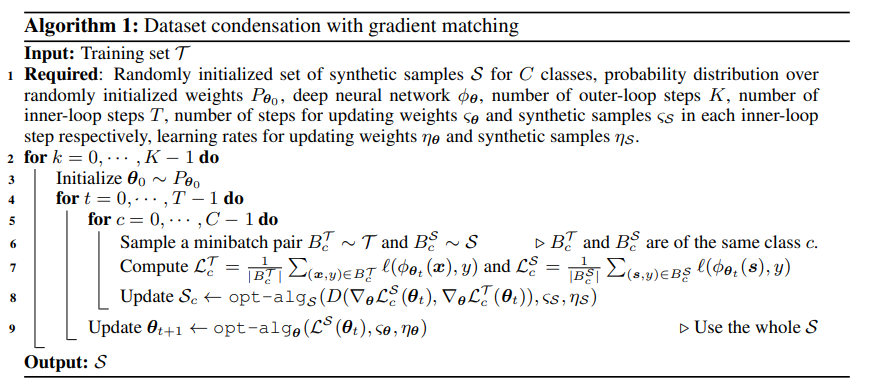







In [14]:
#the function to compute cosine similarity based on dataset condensation original paper
def myCosineSim(array1,array2) :
  assert array1.shape == array2.shape
  if len(array1.shape) == 1 : #bias
    return 0 #(1 - F.cosine_similarity(array1,array2,dim = 0)) 
  elif len(array1.shape) == 2 : #Linear
    return torch.sum(1 - torch.sum(array1*array2,-1)/(torch.norm(array1,dim = -1)*torch.norm(array2,dim = -1) + 1e-6) )
  elif len(array1.shape) == 3 : #Conv
    array1 = array1.reshape(array1.shape[0],array1.shape[1]*array1.shape[2])
    array2 = array2.reshape(array1.shape[0],array1.shape[1]*array1.shape[2])
    return torch.sum(1 - torch.sum(array1*array2,-1)/(torch.norm(array1,dim = -1)*torch.norm(array2,dim = -1) + 1e-6) )
  elif len(array1.shape) == 4 : #Conv 
    out_ch,in_ch,H,W = array1.shape
    array1 = array1.reshape(out_ch,in_ch*H*W)
    array2 = array2.reshape(out_ch,in_ch*H*W)
    return torch.sum(1 - torch.sum(array1*array2,-1)/(torch.norm(array1,dim = -1)*torch.norm(array2,dim = -1) + 1e-6) )

  return None

In [15]:
#Synthesis data class that we are going to optimize
class SynthesisData(nn.Module) :
  def __init__(self,num,initParam = np.array(0)) :
    super(SynthesisData,self).__init__()

    if len(initParam.shape) > 0 : 
      initParam = torch.as_tensor(initParam).float()
      self.synthesisData = nn.Parameter(initParam,requires_grad = True)
    else :
      self.synthesisData = nn.Parameter(torch.rand(10,num,784),requires_grad = True)

In [16]:
K = 1000                              # number of datset training time 
C = len(x_train_divide)               # number of class
T = 1                                 # number of step to train on same model
zetaTheta = 0                         # number of iteration of optimizing model in every step
lrS = 0.1                             # learning rate used to optimizing synthesis dataset
lrTheta = 0.01                        # learning rate used to optimizing synthesis model 
miniBatchSizeInnerReal = 128          # number of minibatch to compute the gradient of real data
miniBatchSizeInnerSysts = 1           # number of minibatch to compute the gradient of synthesis data

In [17]:
numSampleOfSynthesis = 1
SYTS = SynthesisData(numSampleOfSynthesis)
optimSyts = torch.optim.SGD(SYTS.parameters(),lrS)

In [18]:
K = 1000
#Loop of training time K
lossSyts = 0
for k in tqdm(range(K)) :
  #initialize the model,parameter and optimizer for the model
  model = Model2()
  model.to(device)
  optim = torch.optim.SGD(model.parameters(),lrTheta)

  #loop number of step to train the model and dataset
  paramList = list(model.parameters())
  for t in range(T) :
    #loop for all class available
    for c in range(C) :
      #sample data with class c from real dataset 
      randIdxReal = np.random.randint(0,len(x_train_divide[c]),miniBatchSizeInnerReal)
      xRealTrain = x_train_divide[c][randIdxReal]

      #sample data with class c from synthesis dataset       
      randIdxSyts = np.arange(len(SYTS.synthesisData[c]))
      np.random.shuffle(randIdxSyts)
      xSytsTrain = SYTS.synthesisData[c][randIdxSyts[0:miniBatchSizeInnerSysts]]
      xSytsTrain = xSytsTrain.reshape(miniBatchSizeInnerSysts,784)

      #Compute the loss and gradient of synthesis dataset
      #create_graph = True make you can get the gradient of the gradient
      #with respect to synthesis dataset.
      lossSytsC = -torch.mean(torch.log(model.forward(xSytsTrain)[:,c]))
      sytsGrad = torch.autograd.grad(lossSytsC,paramList,create_graph=True)

      #Compute the loss and gradient of real dataset
      #you can think the realGrad as label
      lossRealC = -torch.mean(torch.log(model.forward(xRealTrain)[:,c]))
      realGrad = torch.autograd.grad(lossRealC,paramList)
      
      #Compute the gradient matching loss for every parameter in the model
      loss = 0
      for i in range(len(realGrad)) :
        tempSytsGradFlat = sytsGrad[i]
        tempRealGradFlat = realGrad[i]
        loss = loss  + myCosineSim(tempSytsGradFlat,tempRealGradFlat)  

      #optimize the synthesis dataset
      SYTS.zero_grad()
      loss.backward()
      optimSyts.step()
    
    #Optimize the model with synthesis data with cross entropy Loss
    for itrZ in range(zetaTheta) :
      optim.zero_grad()
      xSytsTrain = model.forward(SYTS.synthesisData)[torch.arange(C),:,torch.arange(C)]
      lossSyts = -torch.mean(torch.log(xSytsTrain)) # cross entropy loss
      lossSyts.backward()
      optim.step()

  if k % 100 == 0 :  
    print('itr:',k,';gradient matching loss :',loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

itr: 0 ;gradient matching loss : tensor(351.6004, device='cuda:0', grad_fn=<AddBackward0>)
itr: 100 ;gradient matching loss : tensor(78.1024, device='cuda:0', grad_fn=<AddBackward0>)
itr: 200 ;gradient matching loss : tensor(80.2959, device='cuda:0', grad_fn=<AddBackward0>)
itr: 300 ;gradient matching loss : tensor(69.7352, device='cuda:0', grad_fn=<AddBackward0>)
itr: 400 ;gradient matching loss : tensor(77.3687, device='cuda:0', grad_fn=<AddBackward0>)
itr: 500 ;gradient matching loss : tensor(76.9594, device='cuda:0', grad_fn=<AddBackward0>)
itr: 600 ;gradient matching loss : tensor(52.2666, device='cuda:0', grad_fn=<AddBackward0>)
itr: 700 ;gradient matching loss : tensor(59.6378, device='cuda:0', grad_fn=<AddBackward0>)
itr: 800 ;gradient matching loss : tensor(87.3867, device='cuda:0', grad_fn=<AddBackward0>)
itr: 900 ;gradient matching loss : tensor(65.3276, device='cuda:0', grad_fn=<AddBackward0>)


In [19]:
#Evaluation
model = Model2()
model.to(device)
optim = torch.optim.SGD(model.parameters(),0.01)

In [20]:
iteration = 1000
for itr in range(iteration) :
  yhat = model.forward(SYTS.synthesisData)
  loss = yhat[torch.arange(C),:,torch.arange(C)]
  loss = -torch.mean(torch.log(loss))

  optim.zero_grad()
  loss.backward()
  optim.step()

In [21]:
print("Synthesis Accuracy :")
print(modelAccuracy(model,x_test,y_test))

Synthesis Accuracy :
0.8716


#5.Visualization
Now that we know the accuracy produced by the algorithm is pretty high,we want to know what kind of picture is the synthesis picture looks like?

in this section you can check it by yourself to what kind of picture the synthesis dataset turn into

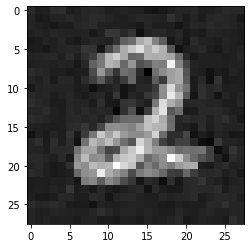

In [22]:
classToVisualize = 2
the_i_th_image = 0
plt.imshow(SYTS.synthesisData[classToVisualize][the_i_th_image].reshape(28,28).detach().numpy(),cmap = 'gray')

#It turn out the result is really interpretable,and the accuracy is far higher
#than the baseline used for this experiment

I think there the accuray I got here is different from the original paper due some of my mistake,because i write the code by myself and only look some part of the original implementation(architecture,hyperparameter,distance,etc) ,i think thre is some detail that i missed when creating this algorithm.


The original work is under MIT license. the link to license of original work is here: <br>
https://github.com/VICO-UoE/DatasetCondensation/blob/master/LICENSE

#6.Reference


1.   <a href = "https://arxiv.org/abs/2006.05929">Dataset Condensation with Gradient Matching</a>
1.   <a href = "https://github.com/VICO-UoE/DatasetCondensation">Dataset Condensation with Gradient Matching official Implementation on github </a>
2.   <a href = "https://arxiv.org/abs/2102.08259">Dataset Condensation with Differentiable Siamese Augmentation
</a>
3.   <a href = "https://arxiv.org/abs/1811.10959">Dataset Distillation</a>